# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

Further adapted from Yan LeCunn's top performing MNIST paper:
[Regularization of Neural Networks using DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf)

https://github.com/j05t/mnist

# Setup libraries and parameters

In [1]:
import time
import pickle
import imageio
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable

In [3]:
# For confusion matrix and 2D embedding
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [4]:
import PIL
import itertools

In [5]:
try:
    # Run this cell to mount your Google Drive.
    data_path = '/content/drive'
    from google.colab import drive
    drive.mount(data_path)
    data_path = os.path.join(data_path, 'My Drive')
except:
    # Just write locally if not in Colaboratory
    data_path = '.'

data_path = os.path.join(data_path, 'checkpoints')
try:
    !mkdir -p "$data_path"
except:
    print('Couldn\'t create', data_path)

print(data_path)

./checkpoints


In [6]:
# Control the resolution of figures plotted below. 200 dpi works well on my macbook
plt.rcParams['figure.dpi'] = 200

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc1 = nn.Linear(4*4*64, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 10)

    # Output fc1 features
    def features(self, x):
        # input: 28 x 28 x 1
        cl1 = self.bn1(F.leaky_relu(self.conv1(x), negative_slope=0.3))
        # layer1: 26 x 26 x 32
        cl2 = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(cl1), negative_slope=0.3),2,2))
        # layer2: 12 x 12 x 32
        cl3 = self.bn3(F.leaky_relu(self.conv3(cl2), negative_slope=0.3))
        # layer3: 10 x 10 x 64
        cl4 = F.max_pool2d(F.leaky_relu(self.conv4(cl3), negative_slope=0.3),2,2)
        # layer4: 4 x 4 x 64
        fc1 = F.leaky_relu(self.fc1(self.bn4(cl4.view(-1, 4*4*64))), negative_slope=0.3)
        # layer5: 512
        return self.bn5(fc1)
    
    def forward(self, x):
        fc1 = self.features(x)
        # layer size 1x128
        fc2 = self.fc2(self.drop1(fc1))
        # layer size 1x10
        return F.log_softmax(fc2, dim=1)

In [8]:
class Optimizer:
    def __init__(self,
                 seed=1,
                 no_cuda=False,
                 #load_checkpoint=12,
                 load_checkpoint=False,
                 checkpoint_path='.'):
        
        self.batch_size=512
        self.test_batch_size=1000
        
        torch.manual_seed(seed)
        self.epoch = 0
        
        use_cuda = not no_cuda and torch.cuda.is_available()
        self.kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = Net().to(self.device)
        
        #self.lr=0.01
        #self.momentum=0.5
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        #self.optimizer = optim.Adadelta(self.model.parameters(), lr=self.lr)
        self.optimizer = optim.Adam(self.model.parameters())
        self.loss_criterion = nn.CrossEntropyLoss(reduction='sum')

        self.checkpoint_path = checkpoint_path
        self.save_checkpoints = True
        self.checkpoint_interval = 10
            
        if load_checkpoint:
            self.load_checkpoint(load_checkpoint)
            self.test(test_loader)

    def set_learning_rate(self, lr):
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        
    def train(self, train_loader):
        # Set model to be in training mode
        self.model.train()
        
        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        mini_batch_losses = []
        for data, target in train_loader:
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = self.loss_criterion(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            mini_batch_losses.append(loss.item())

        return total_loss, correct, mini_batch_losses
        
    def test(self, test_loader):
        # Set model to be in testing mode
        self.model.eval()

        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                total_loss += self.loss_criterion(output, target).item() # sum up batch loss

        return total_loss, correct

    def run_epoch(self, train_loader, test_loader):
        train_start = time.perf_counter()
        train_loss, train_correct, mini_batch_losses = self.train(train_loader)
        train_end = time.perf_counter()
        train_count = len(train_loader.dataset)
        train_delta = train_end - train_start

        test_start = time.perf_counter()
        test_loss, test_correct = self.test(test_loader)
        test_end = time.perf_counter()
        test_count = len(test_loader.dataset)
        test_delta = test_end - test_start

        print('{:5d} | {:5.1f}s, {:4.1f}s | {:6.4f}, {:6.4f} | {:5d}/{:5d} ({:.2f}%), {:4d}/{:4d} ({:5.2f}%)'.format(
            self.epoch,
            train_delta, test_delta,
            train_loss/train_count, test_loss/test_count,
            train_correct, train_count, 100. * train_correct / train_count,
            test_correct, test_count, 100. * test_correct / test_count))
        
        self.epoch = self.epoch + 1
        
        if self.save_checkpoints:
            stats = {"losses" : mini_batch_losses,
                     "train_count" : train_count,
                     "train_correct" : train_correct,
                     "test_count" : test_count,
                     "test_correct" : test_correct}
            
            with open(os.path.join(self.checkpoint_path, 'stats.pkl'), 'ab') as f:
                pickle.dump(stats, f)

            if self.epoch % self.checkpoint_interval == 0:
                self.save_checkpoint(mini_batch_losses)
        
    def run_schedule(self, train_loader, test_loader, schedule):
        for sched in schedule:
            print("Running for {} epochs with a learning rate of {}".format(sched["epochs"], sched["lr"]))
            self.set_learning_rate(sched["lr"])
            self.run(train_loader, test_loader, epochs = sched["epochs"])
            print("")
            
    def run(self, train_loader, test_loader, epochs=False):
        
        if not epochs:
            epochs = self.epochs

        print('Epoch | Time          | Loss           | Accuracy')
        print('      | Train,  Test  | Train,  Test   | Train,                Test')
        for epoch in range(epochs):
            self.run_epoch(train_loader, test_loader)
    
    def save_checkpoint(self, losses=[], prefix='mnist_'):
        checkpoint = {'epoch' : self.epoch,
                      'losses' : losses,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict' : self.optimizer.state_dict(),
                      'loss_criterion' : self.loss_criterion}
        torch.save(checkpoint, os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(prefix, self.epoch)))

    def load_checkpoint(self, epoch, prefix='mnist_'):
        checkpoint = torch.load(os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(prefix, epoch)))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_criterion = checkpoint['loss_criterion']
        for parameter in self.model.parameters():
            parameter.requires_grad = False
        return checkpoint['losses']

In [9]:
opt = Optimizer(checkpoint_path=data_path)

## Network Graph Plotting
These are the graph of functions back propagated through during the call to backward. This is adapted from the [PyTorch tutorial documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

In [10]:
# depth-first search through the back prop functions
def print_graph(fn, depth=0):
    if fn is None:
        return

    print('|'*depth, type(fn).__name__)
    for i in range(len(fn.next_functions)):
        print_graph(fn.next_functions[i][0], depth+1)

In [11]:
# Generate a random input and run it forward
batch_size = 2
input = torch.randn(batch_size,1,28,28).to(opt.device)
output = opt.model(input)

# Run the backward pass, which generates the graph
opt.model.zero_grad()
output.backward(torch.randn(batch_size,10).to(opt.device))

# Print the graph
print_graph(output.grad_fn)

 LogSoftmaxBackward
| AddmmBackward
|| AccumulateGrad
|| MulBackward0
||| NativeBatchNormBackward
|||| LeakyReluBackward0
||||| AddmmBackward
|||||| AccumulateGrad
|||||| NativeBatchNormBackward
||||||| ViewBackward
|||||||| MaxPool2DWithIndicesBackward
||||||||| LeakyReluBackward0
|||||||||| MkldnnConvolutionBackward
||||||||||| NativeBatchNormBackward
|||||||||||| LeakyReluBackward0
||||||||||||| MkldnnConvolutionBackward
|||||||||||||| NativeBatchNormBackward
||||||||||||||| MaxPool2DWithIndicesBackward
|||||||||||||||| LeakyReluBackward0
||||||||||||||||| MkldnnConvolutionBackward
|||||||||||||||||| NativeBatchNormBackward
||||||||||||||||||| LeakyReluBackward0
|||||||||||||||||||| MkldnnConvolutionBackward
||||||||||||||||||||| AccumulateGrad
||||||||||||||||||||| AccumulateGrad
||||||||||||||||||| AccumulateGrad
||||||||||||||||||| AccumulateGrad
|||||||||||||||||| AccumulateGrad
|||||||||||||||||| AccumulateGrad
||||||||||||||| AccumulateGrad
||||||||||||||| AccumulateGrad
|||||

## Print Model Parameter Sizes
How many weights/parameters are there in each expression (portion of a layer) that contribute to the gradient?

In [12]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [13]:
 print_model_size(opt.model)

Model's state_dict:
conv1.weight     torch.Size([32, 1, 3, 3])  : 32 x 9 = 288
conv1.bias       torch.Size([32])           : 32
bn1.weight       torch.Size([32])           : 32
bn1.bias         torch.Size([32])           : 32
bn1.running_mean torch.Size([32])           : 32
bn1.running_var  torch.Size([32])           : 32
conv2.weight     torch.Size([32, 32, 3, 3]) : 32 x 288 = 9,216
conv2.bias       torch.Size([32])           : 32
bn2.weight       torch.Size([32])           : 32
bn2.bias         torch.Size([32])           : 32
bn2.running_mean torch.Size([32])           : 32
bn2.running_var  torch.Size([32])           : 32
conv3.weight     torch.Size([64, 32, 3, 3]) : 64 x 288 = 18,432
conv3.bias       torch.Size([64])           : 64
bn3.weight       torch.Size([64])           : 64
bn3.bias         torch.Size([64])           : 64
bn3.running_mean torch.Size([64])           : 64
bn3.running_var  torch.Size([64])           : 64
conv4.weight     torch.Size([64, 64, 3, 3]) : 64 x 576 = 36

# DataLoaders|
Wrap dataset downloaders in a DataLoader class

In [14]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomAffine(15,translate=(0.1,0.1),scale=(0.9,1.1),shear=None,resample=PIL.Image.BILINEAR),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.batch_size, shuffle=True, **opt.kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.test_batch_size, **opt.kwargs)

# Train (or load) the network

In [15]:
schedule = [
    {"epochs" : 1, "lr" : 0.001},
    {"epochs" : 4, "lr" : 0.1},
    {"epochs" : 12, "lr" : 0.01},
    {"epochs" : 18, "lr" : 0.001}]
opt.run_schedule(train_loader, test_loader, schedule)

Running for 1 epochs with a learning rate of 0.001
Epoch | Time          | Loss           | Accuracy
      | Train,  Test  | Train,  Test   | Train,                Test
    0 | 164.5s,  9.5s | 0.2800, 0.0486 | 55137/60000 (91.89%), 9864/10000 (98.64%)

Running for 4 epochs with a learning rate of 0.1
Epoch | Time          | Loss           | Accuracy
      | Train,  Test  | Train,  Test   | Train,                Test
    1 | 163.4s,  9.2s | 0.9651, 0.2546 | 46887/60000 (78.14%), 9207/10000 (92.07%)
    2 | 161.8s,  9.3s | 0.2115, 0.1319 | 56164/60000 (93.61%), 9627/10000 (96.27%)
    3 | 161.7s,  9.2s | 0.1566, 0.6321 | 57191/60000 (95.32%), 8441/10000 (84.41%)
    4 | 161.0s,  9.2s | 0.1342, 0.0887 | 57623/60000 (96.04%), 9727/10000 (97.27%)

Running for 12 epochs with a learning rate of 0.01
Epoch | Time          | Loss           | Accuracy
      | Train,  Test  | Train,  Test   | Train,                Test
    5 | 159.8s,  9.2s | 0.0788, 0.0362 | 58590/60000 (97.65%), 9891/10000 (98.

In [16]:
schedule = [
    {"epochs" : 2, "lr" : 0.0001}]
opt.run_schedule(train_loader, test_loader, schedule)

Running for 2 epochs with a learning rate of 0.0001
Epoch | Time          | Loss           | Accuracy
      | Train,  Test  | Train,  Test   | Train,                Test
   35 | 159.8s,  9.2s | 0.0239, 0.0136 | 59561/60000 (99.27%), 9956/10000 (99.56%)
   36 | 159.4s,  9.2s | 0.0253, 0.0135 | 59532/60000 (99.22%), 9957/10000 (99.57%)



# Visualization Code

## Create a 2800 x 2800 tiled image from the 10,000 test images

In [17]:
def tile_digits(digits, outputs=None, shape='Square', train=False):
    ds = datasets.MNIST('../data', train=train, transform=transforms.Compose([
                           transforms.ToTensor()]))

    cmap = mpl.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)
    
    def get_img(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < -10:
            return np.zeros((28,28,3)).astype('uint8')
        
        idx = digits[idx]
        if idx < 0:
            clr = cmap(-idx-1)
            img = np.full((28,28,1), 255)
        else:
            clr = cmap(ds[idx][1])
            img = ds[idx][0].numpy().reshape(28,28)*255
            
        return np.dstack([(img*clr[c]).astype('uint8') for c in range(3)])

    def get_target(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return ds[digits[idx]][1]

    def get_class(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return outputs[digits[idx]].argmax(dim=0, keepdim=True).numpy().T[0]

    cnt = len(digits)
    if shape is 'Square':
        cols = np.ceil(np.sqrt(cnt)).astype('int64')
    elif shape is 'Horizontal':
        cols = cnt
    else:
        cols = 1

    img = np.vstack([np.hstack([get_img(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    targets = np.vstack([np.hstack([get_target(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    if outputs is None:
        return img, targets
    else:
        classes = np.vstack([np.hstack([get_class(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])

    return img, targets, classes

In [18]:
tiled, target = tile_digits(range(10000))
imageio.imwrite('tiled.png', tiled)

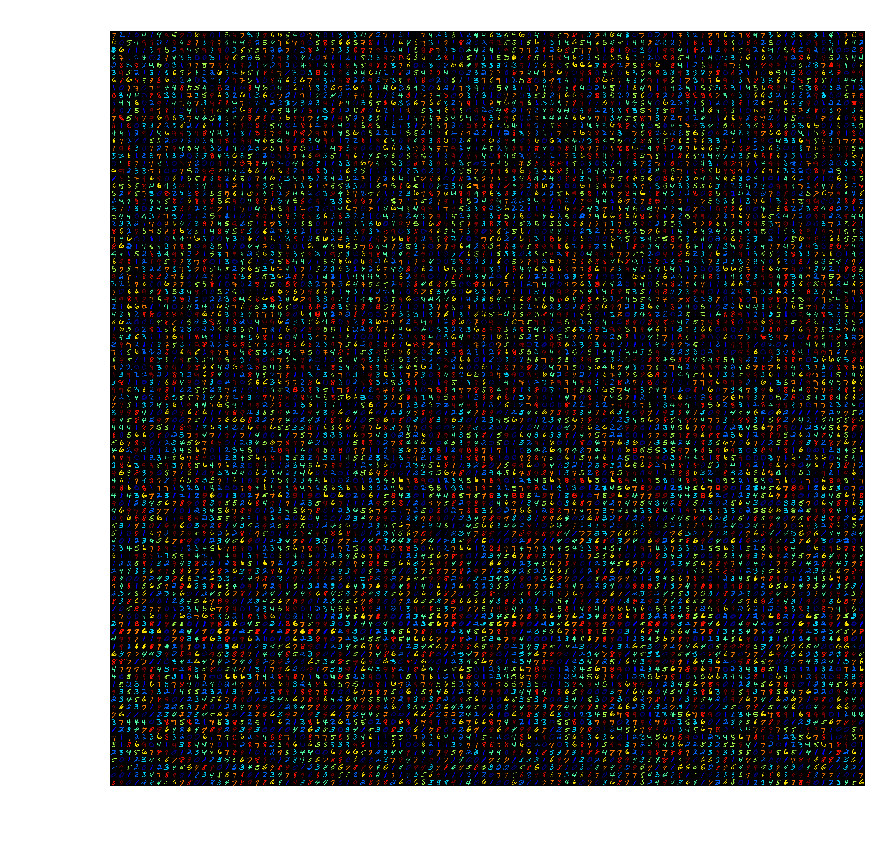

In [19]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(tiled)
plt.show()

## Inspect Failures

In [20]:
def get_failures(model, device, test_loader):
    model.eval()

    batch_offset = 0
    failure_indices = []
    target_all = torch.zeros((0),dtype=torch.long).to(device)
    output_all = torch.zeros((0,10)).to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            target_all = torch.cat((target_all, target))
            output_all = torch.cat((output_all, output))

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            idx = np.where(pred.ne(target.view_as(pred)).to(torch.device("cpu")))[0]
            failure_indices += list(idx + batch_offset)
            
            batch_offset += pred.size(0)
    return np.array(failure_indices), output_all, target_all

In [21]:
failure_indices, output_all, target_all = get_failures(opt.model, opt.device, test_loader)

In [22]:
target_failures = target_all[failure_indices]
failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit).to(torch.device("cpu")))[0], range(0,10)))

# Print sorted failures
sorted_failures = np.hstack(failure_idx_by_digit)
fail_img, targets, classes = tile_digits(failure_indices[sorted_failures], output_all.to(torch.device("cpu")))

print(len(failure_indices))
print('Classifications:\n', classes)
imageio.imwrite('sorted_failures.png', fail_img)


43
Classifications:
 [[ 5  3  7  2  7  7  0]
 [ 7  7  5  2  9  1  3]
 [ 3  3  3  6  0  4  5]
 [ 1  0  8  1  5  1  1]
 [ 2  3  2  1  3  2  5]
 [ 2  2  5  4  4  4  3]
 [ 3 -1 -1 -1 -1 -1 -1]]


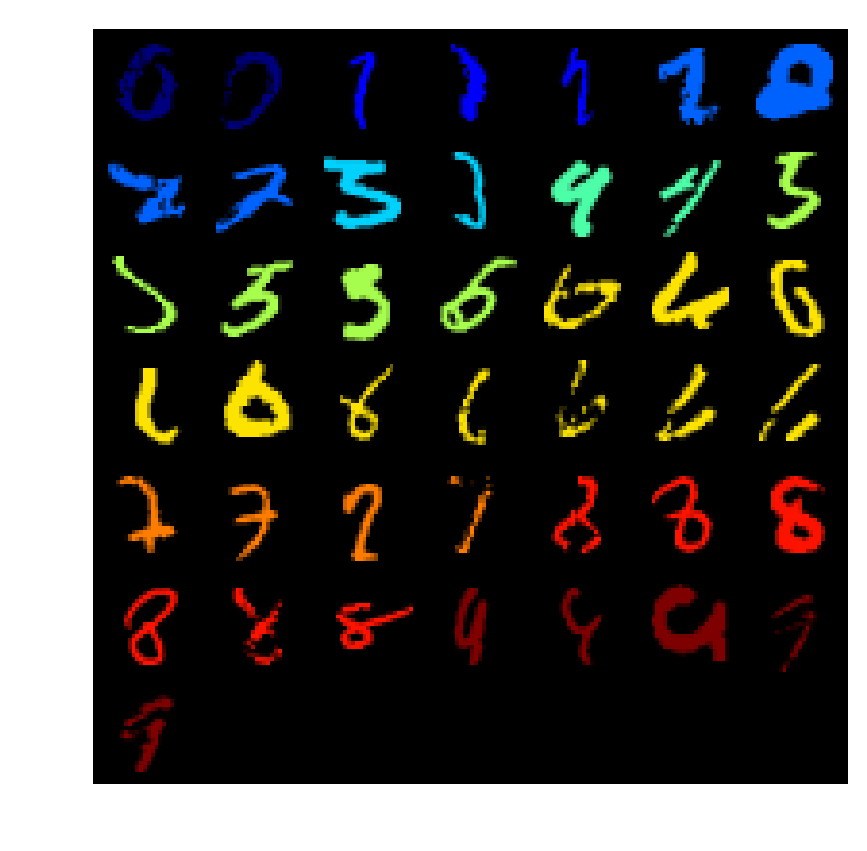

In [23]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(fail_img)
plt.show()

## Plot t-SNE embedding of fc1 features
First extract the fc1 features for each test image and their ground truth values

In [24]:
def get_fc1_features(model, device, dataloader):
    # Set model to be in testing mode
    model.eval()
    with torch.no_grad():
        x = list(map(lambda x: (model.features(x[0].to(device)), x[1].to(device)), dataloader))
        fc1 = torch.cat(list(map(lambda x: x[0].to(torch.device("cpu")), x))).detach().numpy()
        target = torch.cat(list(map(lambda x: x[1].to(torch.device("cpu")), x))).detach().numpy()
        return fc1, target

In [25]:
fc1, target=get_fc1_features(opt.model, opt.device, test_loader)

Embed the 128 dimensional fc1 features in 2D space

In [26]:
X_embedded = TSNE(n_components=2).fit_transform(fc1)

Plot the 2D embedding, color-coded by the ground truth value

10000

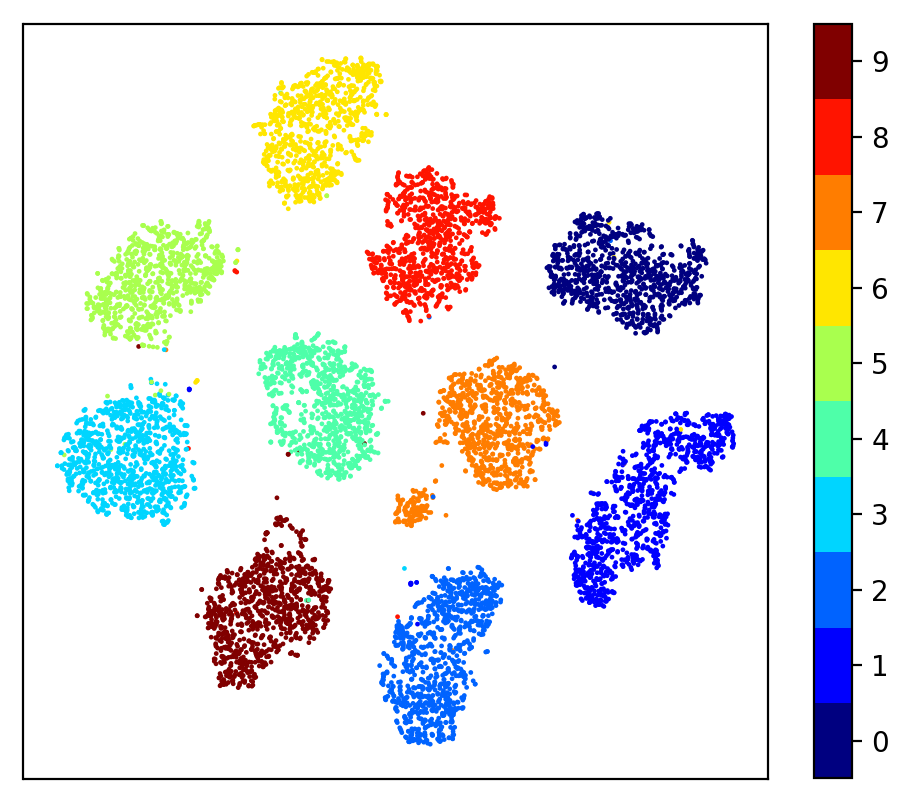

In [27]:
cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

#def onclick(event):
#    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
#          ('double' if event.dblclick else 'single', event.button,
#           event.x, event.y, event.xdata, event.ydata))

fig, (ax0) = plt.subplots(1,1, figsize=(6,5), dpi=200)

#cid = fig.canvas.mpl_connect('button_release_event', onclick)

cs=ax0.scatter(X_embedded[:,0], X_embedded[:,1],
               norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5),
               s=.5, c=target, cmap=cmap)

cb = plt.colorbar(cs, ax=ax0)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])


#ax[1].set_xticks([])
#ax[1].set_yticks([])


len(target)

### How about just 4, 7 and 9

In [28]:
lst = [4,7,9]
fc1_sub=fc1[np.isin(target,lst),:]
target_sub=target[np.isin(target,lst)]

In [29]:
X_embedded_sub = TSNE(n_components=2).fit_transform(fc1_sub)

3019

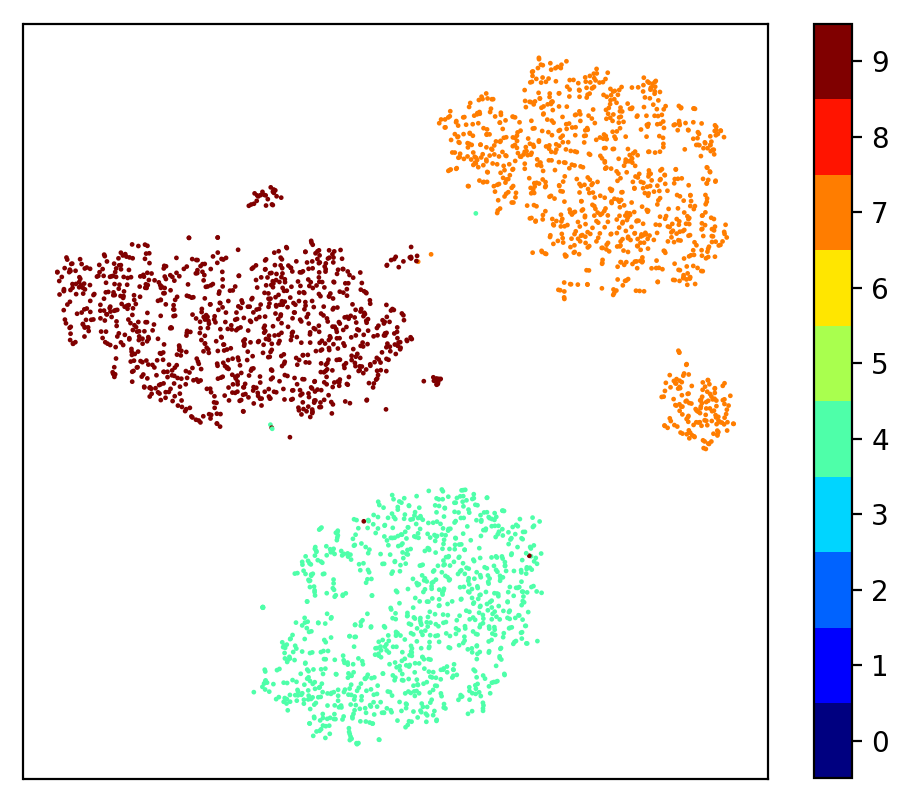

In [30]:
fig, (ax0) = plt.subplots(1,1, figsize=(6,5), dpi=200)

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

cs=plt.scatter(X_embedded_sub[:,0], X_embedded_sub[:,1], s=.5, c=target_sub, cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
cb = plt.colorbar(cs)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])
len(target_sub)

## What are the Nearest Neighbors for Failures?

In [31]:
# DataLoaders for train and test data
train_loader_fc1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.batch_size, shuffle=False, **opt.kwargs)

train_fc1, train_target=get_fc1_features(opt.model, opt.device, train_loader_fc1)

In [32]:
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(train_fc1)
distances, indices = nbrs.kneighbors(fc1[failure_indices[sorted_failures],:])

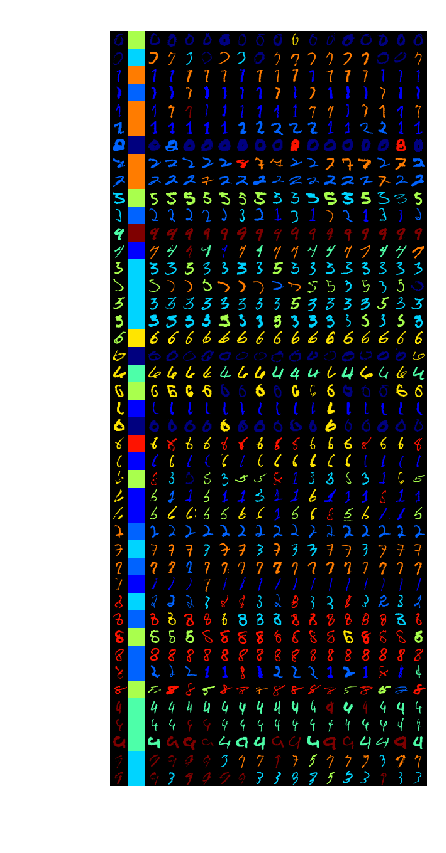

In [33]:
cnt = len(sorted_failures)

failure_classes = output_all[failure_indices[sorted_failures]].argmax(dim=1, keepdim=True) # get the index of the max log-probability

failure_img = tile_digits(failure_indices[sorted_failures], shape='Vertical')[0]
failure_classification_img = tile_digits((-failure_classes.to(torch.device("cpu")).numpy()-1).transpose()[0], shape='Vertical')[0]
neigh_img = np.vstack([tile_digits(indices[idx,:], shape='Horizontal', train=True)[0] for idx in range(cnt)])

imageio.imwrite('neighbors_train.png', np.hstack([failure_img, failure_classification_img, neigh_img]))

fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
ax.imshow(np.hstack([failure_img, failure_classification_img, neigh_img]))

plt.show()

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

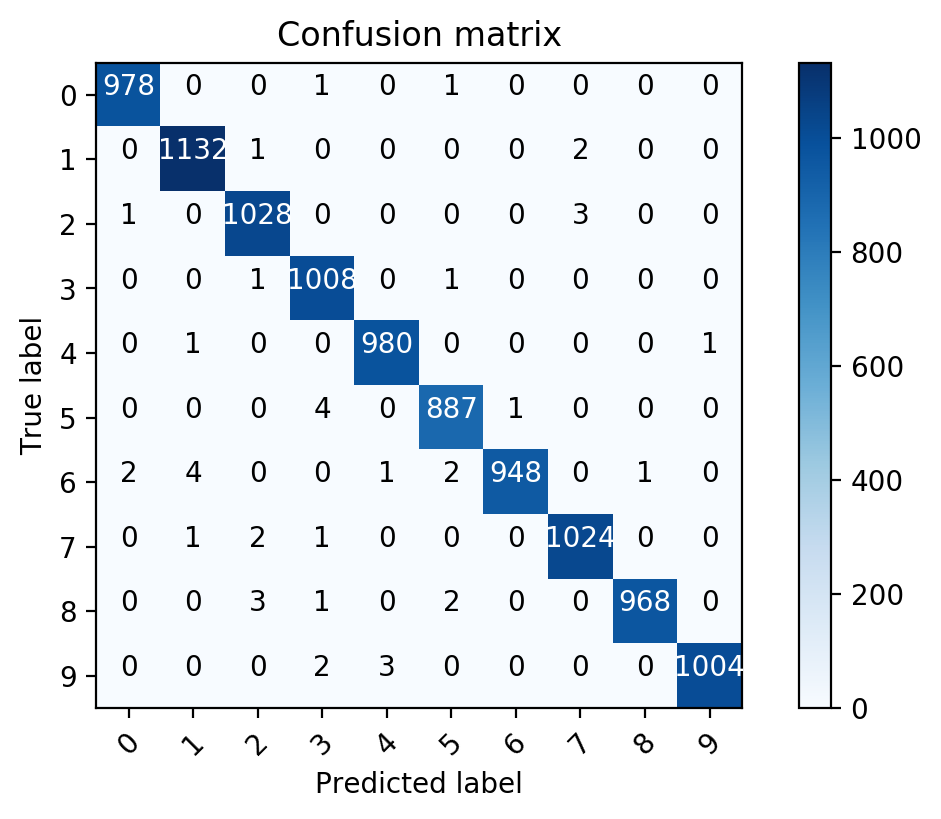

In [35]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all.to(torch.device("cpu")), pred_all.to(torch.device("cpu"))) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Look at weights/kernels

In [36]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]
    #np.linalg.svd()

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

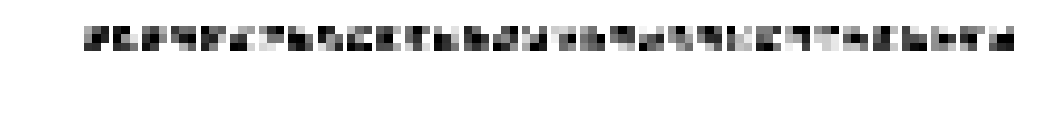

In [37]:
plot_kernels(opt.model.state_dict()['conv1.weight'].permute(1,0,2,3).to(torch.device("cpu")))

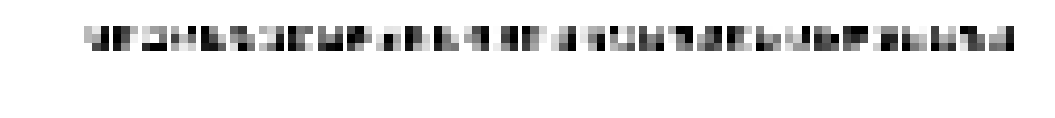

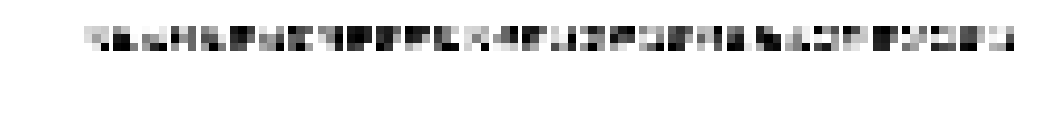

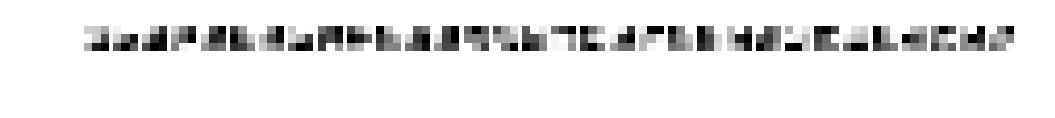

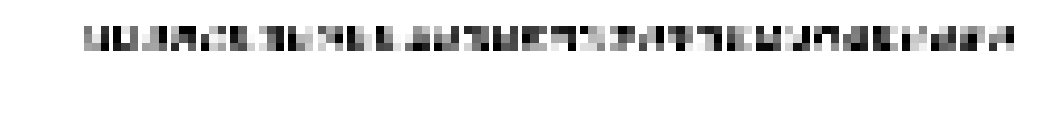

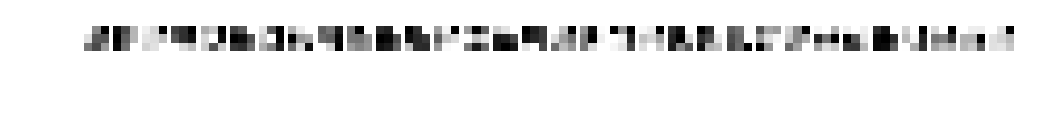

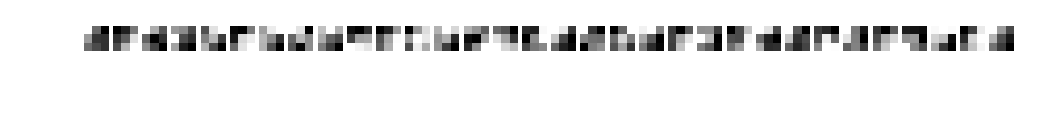

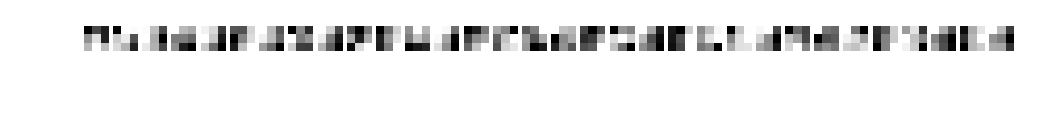

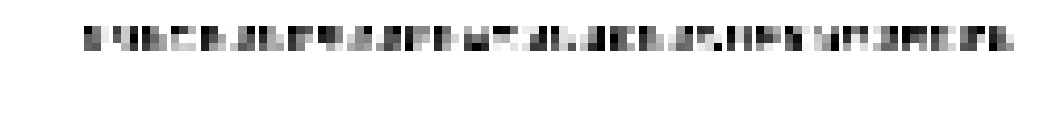

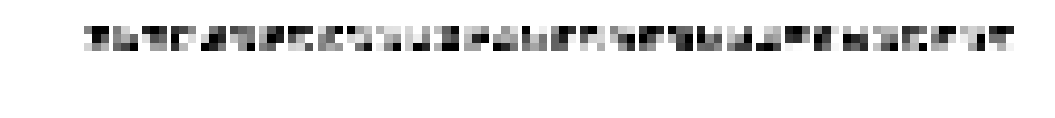

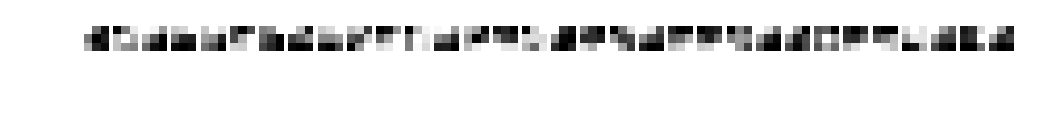

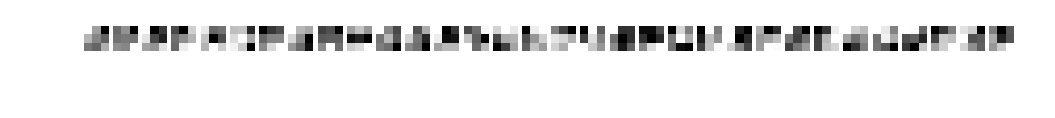

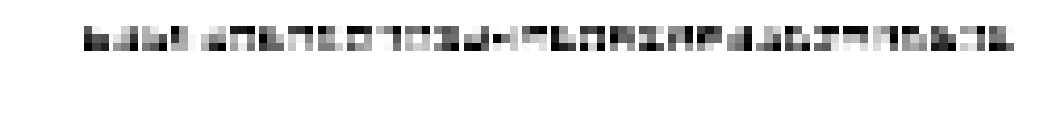

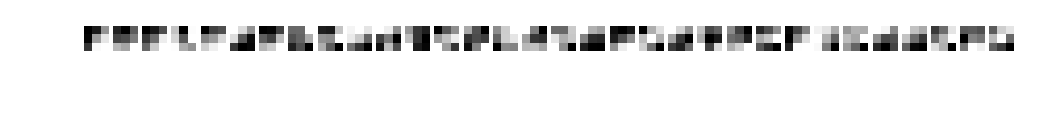

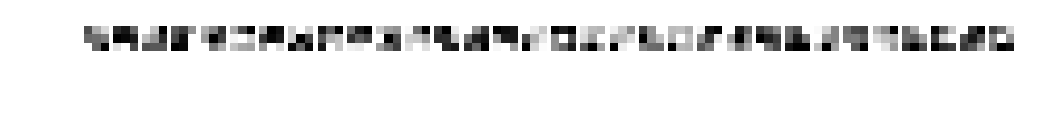

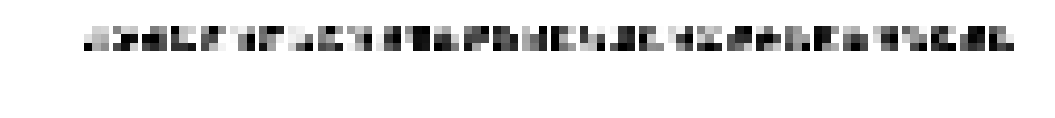

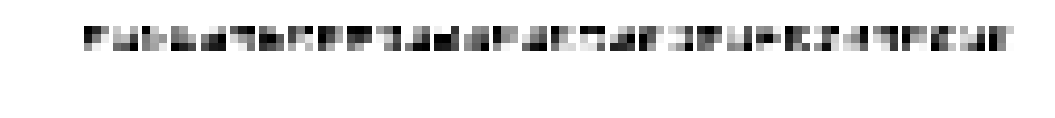

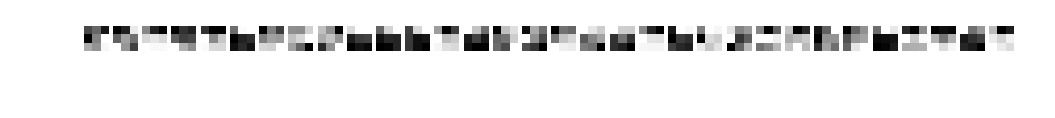

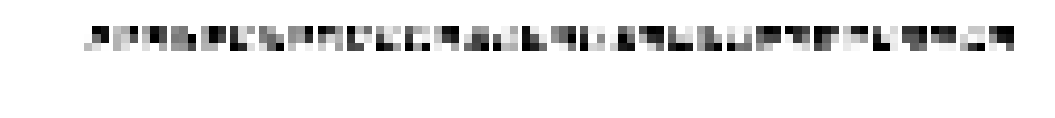

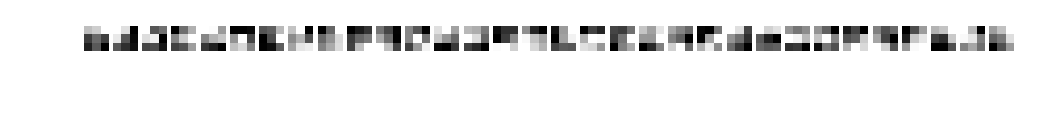

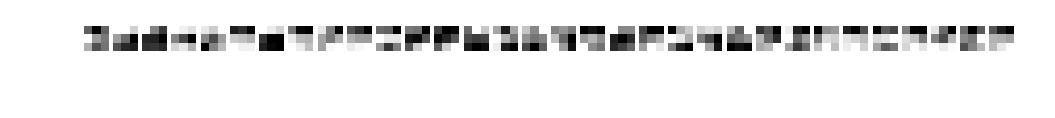

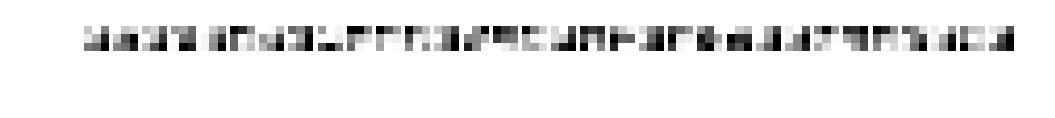

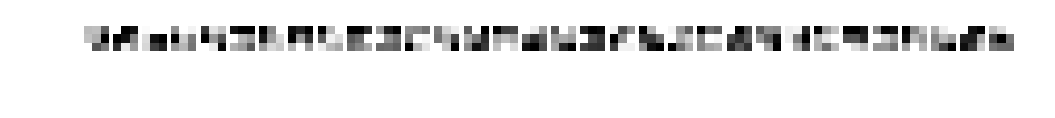

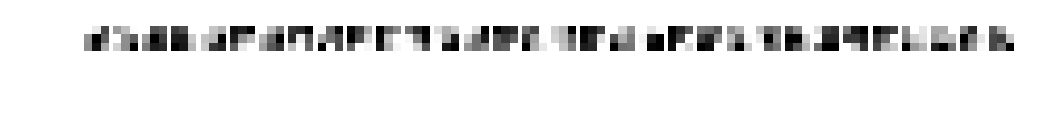

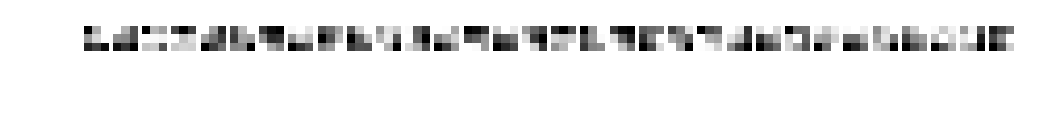

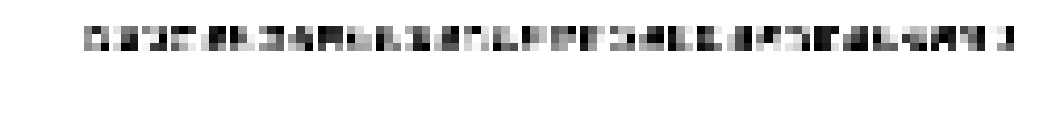

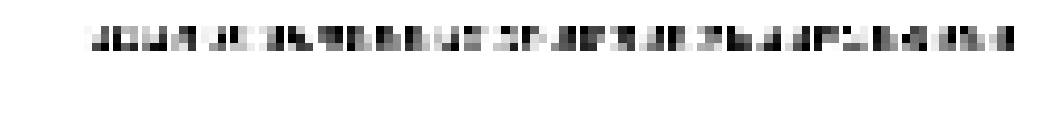

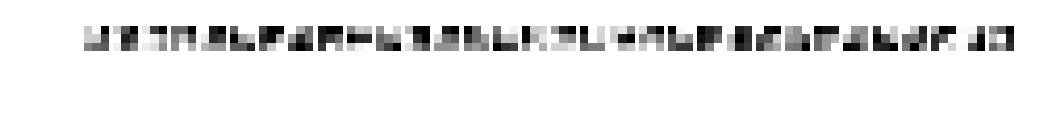

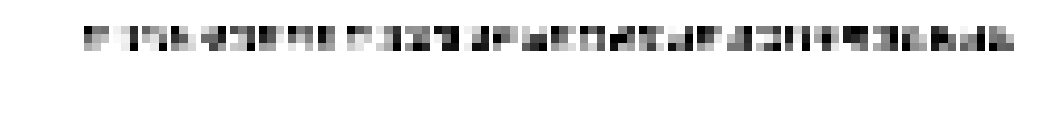

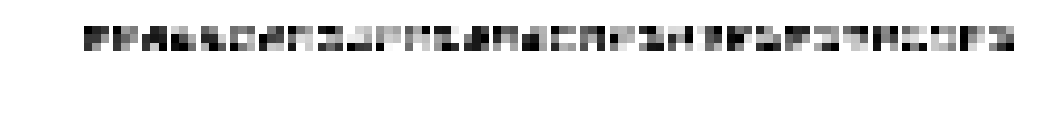

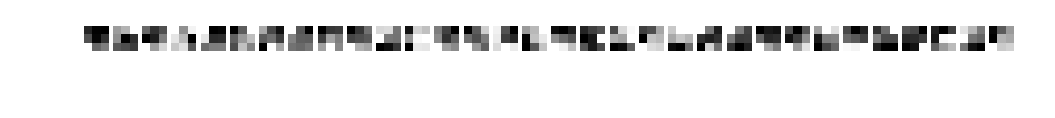

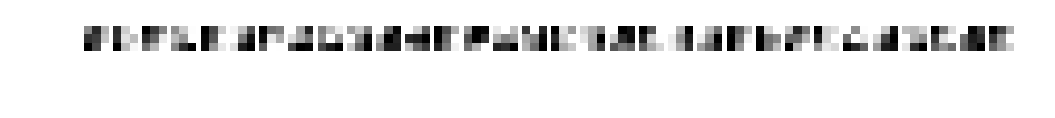

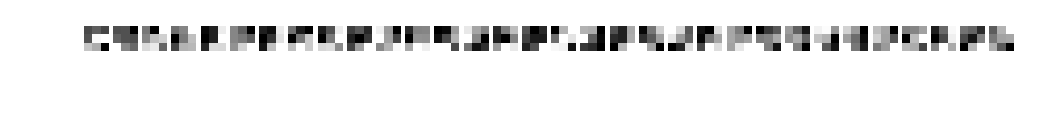

In [38]:
plot_kernels(opt.model.state_dict()['conv2.weight'].to(torch.device("cpu")))